In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

In [6]:
f_mnist = FashionMNIST("", train = True, download = True,
                       transform = Compose([ToTensor(), Normalize(mean = (0.5,), std = (0.5,))]))

Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw


Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label:  9
torch.Size([1, 28, 28])


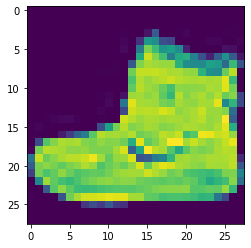

In [29]:
img, label = f_mnist[0]
print("Label: ", label)
import matplotlib.pyplot as plt
plt.imshow(img.view([28, 28]))
print(img.shape)

In [30]:
torch.min(img), torch.max(img)

(tensor(-1.), tensor(1.))

In [31]:
def denorm(x):
  out = (x+1) / 2
  return out.clamp(0, 1)

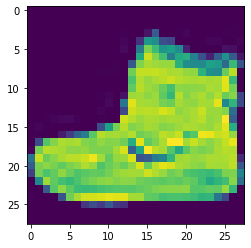

In [32]:
img_norm = denorm(img)
plt.imshow(img_norm[0])

In [35]:
from torch.utils.data import DataLoader

batch_size = 50
data_loader = DataLoader(f_mnist, batch_size, shuffle = True)

First Batch
torch.Size([50, 1, 28, 28])
tensor([1, 4, 3, 2, 5, 4, 9, 5, 2, 8, 2, 2, 7, 9, 3, 3, 6, 6, 7, 1, 0, 9, 3, 6,
        8, 3, 8, 3, 5, 0, 9, 3, 9, 6, 8, 9, 7, 0, 4, 7, 8, 5, 4, 9, 2, 1, 7, 9,
        0, 3])


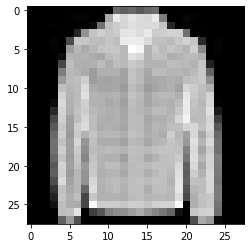

In [41]:
for img_batch, label_batch in data_loader:
  print("First Batch")
  print(img_batch.shape)
  plt.imshow(img_batch[5][0], cmap = 'gray')
  print(label_batch)
  break

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
device

device(type='cuda')

In [44]:
image_size = 28 * 28
hidden_size = 256

In [50]:
import torch.nn as nn

#discriminator (to classify real or fake)
model_dis = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

In [71]:
model_dis.to(device);

In [75]:
#Generator
latent_size = 64

model_gen = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [76]:
model_gen

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [77]:
y = model_gen(torch.randn(2, latent_size))
y.reshape(-1, 28, 28).shape

torch.Size([2, 28, 28])

In [78]:
gen_images = denorm(y.reshape((-1,28, 28)).detach())

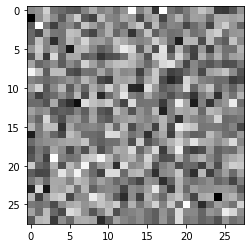

In [80]:
plt.imshow(gen_images[0], cmap = 'gray') #random noise

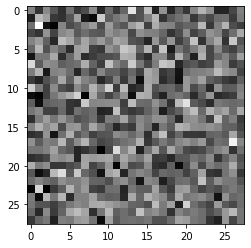

In [82]:
plt.imshow(gen_images[1], cmap = 'gray')


In [83]:
model_gen.to(device);

In [85]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(model_dis.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(model_gen.parameters(), lr = 0.0002)

In [120]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()


def train_discriminator(images):
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  #loss for real
  outputs = model_dis(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs

  #loss for fake
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = model_gen(z)
  outputs= model_dis(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)
  fake_score = outputs

  d_loss = d_loss_real + d_loss_fake
  rest_grad()

  d_loss.backward()

  d_optimizer.step()

  return d_loss, real_score, fake_score

In [97]:
'''
z = torch.randn(batch_size, latent_size).to(device)
fake_images = model_gen(z)
model_dis(fake_images)
'''

'\nz = torch.randn(batch_size, latent_size).to(device)\nfake_images = model_gen(z)\nmodel_dis(fake_images)\n'

In [121]:
def train_generator():
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_images = model_gen(z)
  labels = torch.ones(batch_size,1 ).to(device)
  g_loss = criterion(model_dis(fake_images), labels)

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

In [122]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

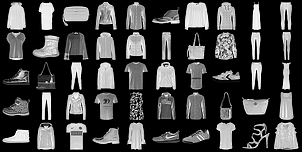

In [123]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


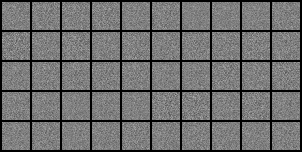

In [124]:

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = model_gen(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [125]:


num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/1200], d_loss: 0.1021, g_loss: 2.8659, D(x): 0.98, D(G(z)): 0.08
Epoch [0/300], Step [400/1200], d_loss: 0.0678, g_loss: 2.4925, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [600/1200], d_loss: 0.0786, g_loss: 0.8698, D(x): 0.96, D(G(z)): 0.03
Epoch [0/300], Step [800/1200], d_loss: 0.0236, g_loss: 1.7598, D(x): 0.99, D(G(z)): 0.02
Epoch [0/300], Step [1000/1200], d_loss: 0.0808, g_loss: 1.9319, D(x): 0.95, D(G(z)): 0.02
Epoch [0/300], Step [1200/1200], d_loss: 0.0649, g_loss: 4.5684, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/1200], d_loss: 0.0500, g_loss: 2.2499, D(x): 1.00, D(G(z)): 0.04
Epoch [1/300], Step [400/1200], d_loss: 0.0504, g_loss: 2.7448, D(x): 0.98, D(G(z)): 0.00
Epoch [1/300], Step [600/1200], d_loss: 0.0469, g_loss: 1.1628, D(x): 0.97, D(G(z)): 0.01
Epoch [1/300], Step [800/1200], d_loss: 0.0650, g_loss: 2.1136, D(x): 0.96, D(G(z)): 0.00
Epoch [1/300], Step [1000/1200], d_loss: 0.0736, g_loss: 1.6947, D(x):